In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import gpytorch
import numpy as np
import torch
import winsound
from matplotlib import pyplot as plt
from LDGD.model import LDGD, FastLDGD, VAE
from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood

import json
%matplotlib inline
%load_ext autoreload
%autoreload 2
duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
def create_dataset(random_state, test_size, dataset='mnist', **kwargs):
    if dataset == 'mnist':
        mnist_train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
        mnist_test = MNIST(root='./data', train=False, download=True, transform=ToTensor())

        # Flatten the images and convert labels
        x_train = mnist_train.data.view(mnist_train.data.size(0), -1).numpy()
        x_train = x_train/x_train.max()
        y_train = mnist_train.targets.numpy()

        # Concatenate train and test sets to split them later
        x_test = mnist_test.data.view(mnist_test.data.size(0), -1).numpy()
        x_test = x_test/x_test.max()
        y_test = mnist_test.targets.numpy()

        # One-hot encode the labels
        y_one_hot_train = np.zeros((y_train.shape[0], len(np.unique(y_train))))
        y_one_hot_train[np.arange(y_train.shape[0]), y_train] = 1

        y_one_hot_test = np.zeros((y_test.shape[0], len(np.unique(y_test))))
        y_one_hot_test[np.arange(y_test.shape[0]), y_test] = 1

        orig_data = None  # No original data in the case of MNIST


    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_one_hot_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_one_hot_test, dtype=torch.float32)
    y_train_labels_tensor = torch.tensor(y_train)
    y_test_labels_tensor = torch.tensor(y_test)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_labels_tensor, y_test_labels_tensor, orig_data


In [3]:
def create_LDGD_model(data_cont, data_cat, ldgd_settings, batch_shape, x_init='pca'):
    if ldgd_settings['use_gpytorch'] is False:
        pass
    else:
        kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
        kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = LDGD(data_cont,
             kernel_reg=kernel_reg,
             kernel_cls=kernel_cls,
             num_classes=data_cat.shape[-1],
             latent_dim=ldgd_settings['latent_dim'],
             num_inducing_points_cls= ldgd_settings['num_inducing_points_cls'],
             num_inducing_points_reg= ldgd_settings['num_inducing_points_reg'],
             likelihood_reg=likelihood_reg,
             likelihood_cls=likelihood_cls,
             use_gpytorch=ldgd_settings['use_gpytorch'],
             shared_inducing_points=ldgd_settings['shared_inducing_points'],
             use_shared_kernel=False,
             x_init=x_init,
             device=device)

    return model

def create_FastLDGD_model(data_cont, data_cat, batch_shape, ldgd_settings):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = FastLDGD(data_cont,
             kernel_reg=kernel_reg,
             kernel_cls=kernel_cls,
             num_classes=data_cat.shape[-1],
             latent_dim=ldgd_settings['latent_dim'],
             num_inducing_points_cls= ldgd_settings['num_inducing_points_cls'],
             num_inducing_points_reg= ldgd_settings['num_inducing_points_reg'],
             likelihood_reg=likelihood_reg,
             likelihood_cls=likelihood_cls,
             use_gpytorch=ldgd_settings['use_gpytorch'],
             shared_inducing_points=ldgd_settings['shared_inducing_points'],
             use_shared_kernel=False,
             device=device)

    return model

In [7]:
model_settings = {
    'latent_dim': 10,
    'num_inducing_points_reg': 100,
    'num_inducing_points_cls': 100,
    'num_epochs_train': 20000,
    'num_epochs_test': 20000,
    'batch_size': 700,
    'load_trained_model': False,
    'load_tested_model': False,
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 65,
    'test_size': 0.2,
    'cls_weight': 1.0,
    'reg_weight': 1.0,
    'num_samples': 500,

}
np.random.seed(model_settings['random_state'])


In [8]:
# load raw data
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, _ = create_dataset(random_state=model_settings['random_state'], test_size=0.2, dataset='mnist')
yn_train = yn_train/yn_train.max()
yn_test = yn_test/yn_test.max()


In [12]:
load_saved_result = False
batch_shape = torch.Size([yn_train.shape[-1]])
metric_fastldgd_list = []
model = create_LDGD_model(data_cont=yn_train, data_cat=ys_train, ldgd_settings=model_settings, batch_shape=batch_shape)

if load_saved_result is False:
    losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                              epochs=model_settings['num_epochs_train'],
                                              batch_size=model_settings['batch_size'], monitor_mse=False)
    model.save_wights(path_save='./saved_models/', file_name=f"model_mnist_fast")
else:
    model.load_weights(path_save='./saved_models/', file_name=f"model_mnist_fast.pth")


winsound.Beep(freq, duration*3)


Epoch 1/20000, Loss: 1041.725830078125
Epoch 11/20000, Loss: 1010.3026733398438
Epoch 21/20000, Loss: 983.3748779296875
Epoch 31/20000, Loss: 955.5848999023438
Epoch 41/20000, Loss: 930.3952026367188
Epoch 51/20000, Loss: 901.4111938476562
Epoch 61/20000, Loss: 870.3040771484375
Epoch 71/20000, Loss: 836.9196166992188
Epoch 81/20000, Loss: 795.9500122070312
Epoch 91/20000, Loss: 738.2861938476562
Epoch 101/20000, Loss: 682.35595703125
Epoch 111/20000, Loss: 616.8128051757812
Epoch 121/20000, Loss: 555.673828125
Epoch 131/20000, Loss: 478.9475402832031
Epoch 141/20000, Loss: 403.3074035644531
Epoch 151/20000, Loss: 342.3610534667969
Epoch 161/20000, Loss: 270.3980712890625
Epoch 171/20000, Loss: 213.35052490234375
Epoch 181/20000, Loss: 144.14080810546875
Epoch 191/20000, Loss: 89.49055480957031
Epoch 201/20000, Loss: 32.62071990966797
Epoch 211/20000, Loss: -19.454757690429688
Epoch 221/20000, Loss: -65.7025375366211
Epoch 231/20000, Loss: -112.01048278808594
Epoch 241/20000, Loss: -15

In [13]:
predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                    epochs=model_settings['num_epochs_test'])
winsound.Beep(freq, duration*3)


Epoch 1/20000, Loss: 25.550338745117188
Epoch 11/20000, Loss: 32.236053466796875
Epoch 21/20000, Loss: -153.94590759277344
Epoch 31/20000, Loss: -44.68667221069336
Epoch 41/20000, Loss: -78.46133422851562
Epoch 51/20000, Loss: -209.46426391601562
Epoch 61/20000, Loss: -172.7415313720703
Epoch 71/20000, Loss: -161.3223114013672
Epoch 81/20000, Loss: -74.45147705078125
Epoch 91/20000, Loss: -116.79960632324219
Epoch 101/20000, Loss: -250.4695281982422
Epoch 111/20000, Loss: -277.36749267578125
Epoch 121/20000, Loss: -207.9607391357422
Epoch 131/20000, Loss: -236.42724609375
Epoch 141/20000, Loss: -271.5357666015625
Epoch 151/20000, Loss: -259.0132141113281
Epoch 161/20000, Loss: -268.68743896484375
Epoch 171/20000, Loss: -217.81890869140625
Epoch 181/20000, Loss: -169.46658325195312
Epoch 191/20000, Loss: -307.5086364746094
Epoch 201/20000, Loss: -275.28515625
Epoch 211/20000, Loss: -298.10150146484375
Epoch 221/20000, Loss: -161.56275939941406
Epoch 231/20000, Loss: -242.01177978515625


In [ ]:
metrics

In [14]:

alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x = model.x.q_mu.cpu().detach().numpy()
std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

x_test = model.x_test.q_mu.cpu().detach().numpy()
std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()

inducing_points = (history_test['z_list_reg'][-1], history_test['z_list_cls'][-1])

latent_dim = x.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

 D:\Navid\Projects\LDGD\src\LDGD\visualization\vizualize_utils.py:319: UserWarning:No contour levels were found within the data range.
 D:\Navid\Projects\LDGD\src\LDGD\visualization\vizualize_utils.py:319: UserWarning:The following kwargs were not used by contour: 'label'


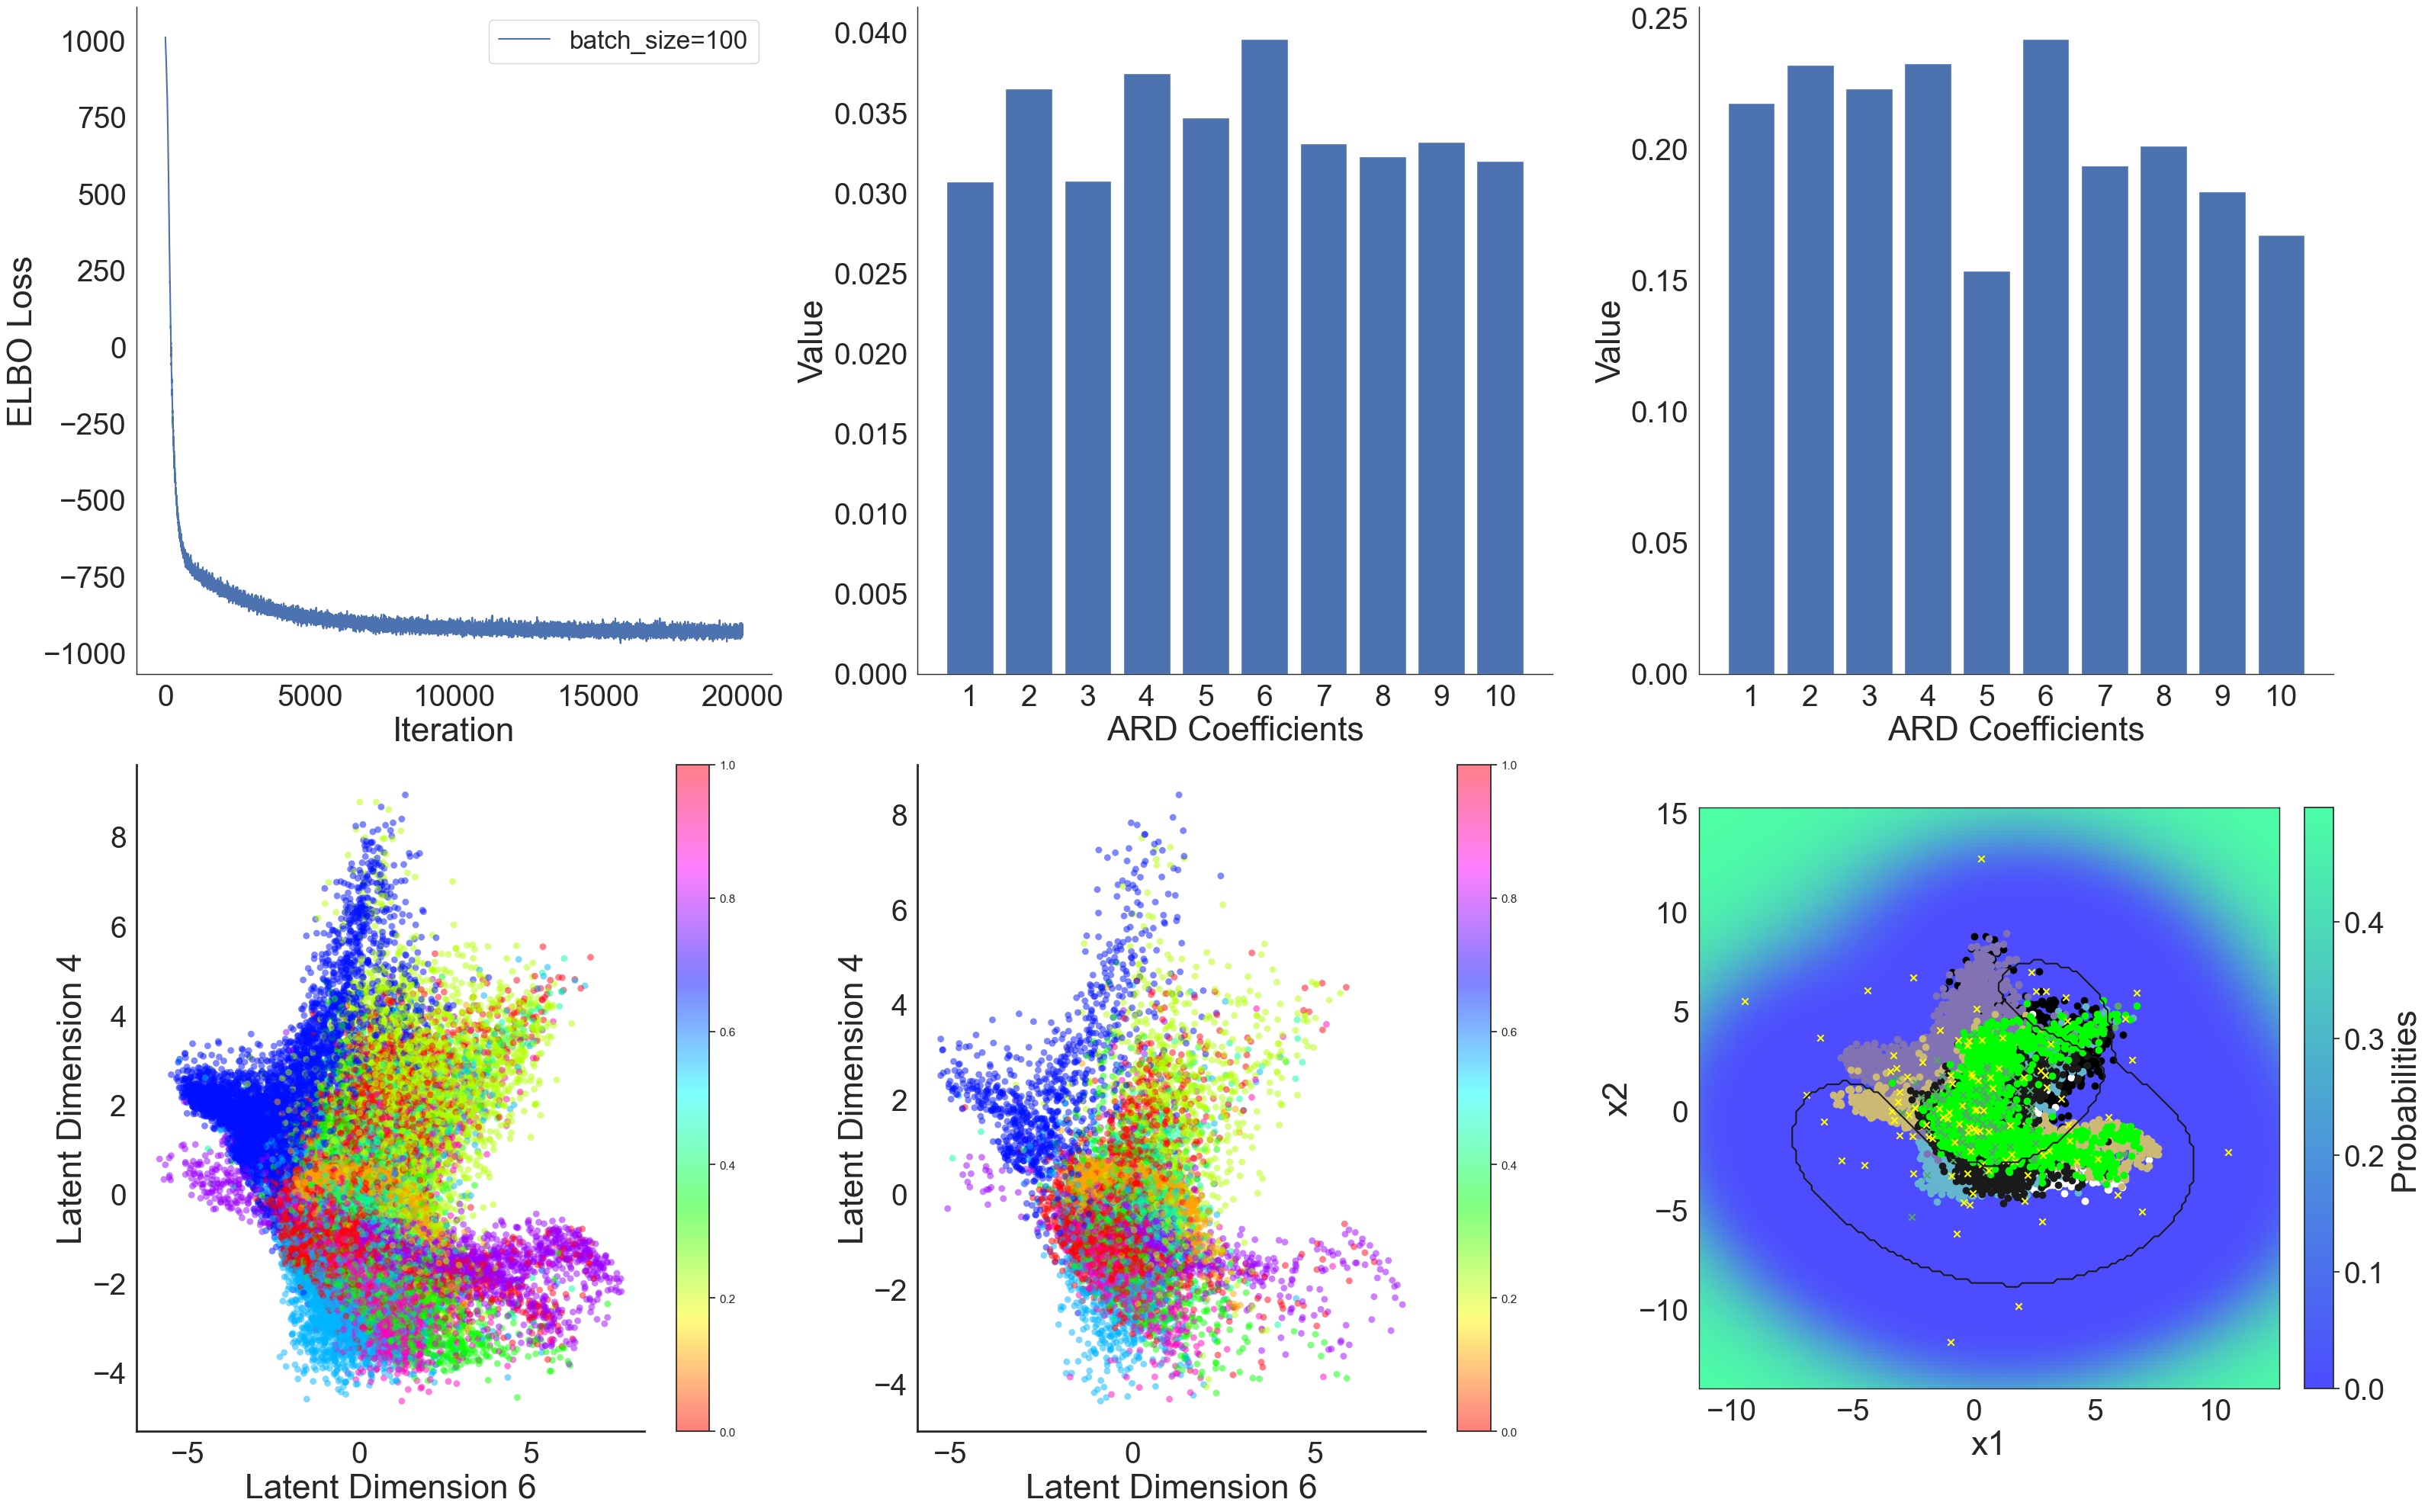

In [15]:
color_list = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'lime', 'navy', 'teal']
fig, axs = plt.subplots(2,3, figsize=(32, 20))


plot_loss_gplvm(losses, ax=axs[0,0])
plot_ARD_gplvm(model_settings['latent_dim'], alpha_cls, ax=axs[0,2])
plot_ARD_gplvm(model_settings['latent_dim'], alpha_reg, ax=axs[0,1])
plot_scatter_gplvm(x, labels_train, l1=l1, l2=l2, ax=axs[1,0], colors=color_list, show_errorbars=False, std=std)
plot_scatter_gplvm(x_test, labels_test, l1=l1, l2=l2, ax=axs[1,1], colors=color_list, show_errorbars=False, std=std_test)

plot_heatmap(x, labels_train, model, alpha_cls, cmap='winter', range_scale=1.2,
             file_name='latent_heatmap_train', inducing_points=inducing_points, ax1=axs[1,2], fig=fig)


plt.tight_layout()
fig.savefig("ARD_synthetic4.png")
fig.savefig("ARD_synthetic4.svg")

In [ ]:
rec_img, predictions_std = model.regress_x(x_test[1:45])
plt.imshow(rec_img.view(-1,28,28).cpu().detach().numpy()[14], cmap='gray')
#plt.imshow(predictions_std.view(-1,28,28).cpu().detach().numpy()[5], cmap='gray')


In [ ]:
num_images = rec_img.size(0)
random_indices = np.random.choice(num_images, 9, replace=False)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for idx, ax in zip(random_indices, axes.ravel()):
    # Convert tensor image to numpy and display it
    img = rec_img.view(-1, 28, 28).cpu().detach().numpy()[idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.savefig("generation_mnist.png")
plt.show()

In [ ]:
num_images = rec_img.size(0)
random_indices = np.random.choice(num_images, 9, replace=False)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(1, 9, figsize=(50, 9))

for idx, ax in zip(random_indices, axes.ravel()):
    # Convert tensor image to numpy and display it
    img = rec_img.view(-1, 28, 28).cpu().detach().numpy()[idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.savefig("generation_mnist2.png")
plt.show()

In [ ]:
from time import time

import numpy as np
import pandas as pd


# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
mnist_train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='./data', train=False, download=True, transform=ToTensor())

x = mnist_train.data.view(mnist_train.data.size(0), -1).numpy()
y = mnist_train.targets.numpy()

# Concatenate train and test sets to split them later
X_test = mnist_test.data.view(mnist_test.data.size(0), -1).numpy()
X_test = X_test/X_test.max()
y_test = mnist_test.targets.numpy()

In [ ]:
standardized_data = StandardScaler().fit_transform(x)
print(standardized_data.shape)
x_subset = x[0:10000]
y_subset = y[0:10000]

In [ ]:
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset)

In [ ]:
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=y_subset, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through t-SNE', fontsize=24)

In [ ]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points_reg': 10,
    'num_inducing_points_cls': 10,
    'num_epochs_train': 2000,
    'num_epochs_test': 2000,
    'batch_size': 1000,
    'load_trained_model': False,
    'load_tested_model': False,
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 65,
    'test_size': 0.2,
    'cls_weight': 0.0,
    'reg_weight': 1.0,

}
y_one_hot_subset = np.zeros((y_subset.shape[0], len(np.unique(y_subset))))
y_one_hot_subset[np.arange(y_subset.shape[0]), y_subset] = 1


batch_shape = torch.Size([x_subset.shape[-1]])
metric_fastldgd_list = []
model = create_LDGD_model(data_cont=torch.tensor(x_subset/x_subset.max()), data_cat=torch.tensor(y_one_hot_subset), ldgd_settings=model_settings, batch_shape=batch_shape, x_init=None)

losses, history_train = model.train_model(yn=torch.tensor(x_subset/x_subset.max()), ys=torch.tensor(y_one_hot_subset),
                                          epochs=model_settings['num_epochs_train'],
                                          batch_size=model_settings['batch_size'], monitor_mse=False)


winsound.Beep(freq, duration*3)


In [ ]:
alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

latent_mean = model.x.q_mu.cpu().detach().numpy()
latent_std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

inducing_points = (history_train['z_list_reg'][-1], history_train['z_list_cls'][-1])

latent_dim = latent_mean.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

In [ ]:
plt.scatter(latent_mean[:, l1], latent_mean[:, l2], s= 5, c=y_subset, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through t-SNE', fontsize=24)